# Benchmarks for Streamline Generic Pipeline 

## Libraries

In [1]:
import numpy as np
import polars as pl
import pandas as pd

from rich import print
from rich.pretty import pprint

from markov_decision_process import TimeAugmentedMDP


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
## Benchmarks 

BENCHMARKS = {
    'static-demand': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0,
        'time_effect': 0.0,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
   'time-varying-demand': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0,
        'time_effect': 0.05,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
   'peak-varying-demand': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0.075,
        'time_effect': 0.0,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
   'all-effects': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0.075,
        'time_effect': 0.05,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
}

## Utility functions

In [3]:
class DummyData:
    """
    Generates dummy data for testing purposes.

    Produces a data frame of services where:
    - each service has a unique id
    - it departs at a given time of year
    - there is seasonal cycle to the demand for the service
    - demand for the service increases closer to departure date.
    """

    def __init__(
        self,
        num_periods: int = 100,
        price_effect: float = 0.08,
        peak_effect: float = 0.5,
        time_effect: float = 0.05,
        capacity: float = 500,
        prices: list[float] = [10, 20, 30, 40],
    ):
        self.T = num_periods
        assert self.T > 0, "Number of periods must be greater than 0."

        self.price_effect = price_effect
        self.peak_effect = peak_effect
        self.time_effect = time_effect
        self.prices = prices
        self.capacity = capacity

        self.noise_std = 0.1

        return None

    def demand_curve(
        self,
        price: np.ndarray,
        t: np.ndarray,
        peak: np.ndarray,
    ) -> np.ndarray:
        """
        Generate demand for a service.
        """

        Q = (
            50
            * (np.exp(-self.price_effect * price) + self.peak_effect * peak)
            * np.exp(-self.time_effect * np.abs(t))
        )

        return Q

## Problem Setup

Note that in this problem we have a large state and action space. To have this compute efficiently, we 
need to ensure that our transition and reward functions are vectorized; in the sense that they will accept numpy arrays/pandas colums.

In [4]:
def solve_markov_decision_process(
    params: dict
) -> TimeAugmentedMDP:
    """
    Solve the Markov Decision Process using value iteration.
    """

    print(f"Solving MDP with parameters: {params}")

    # Instantiate the dummy data generator
    dummy_data = DummyData(**params)

    states: list[float] = np.linspace(0, dummy_data.capacity, 501).tolist()
    actions: list[float] = dummy_data.prices
    times: list[int] = np.arange(-dummy_data.T, 1).tolist()


    def reward(
        s_prime: float,
        s: float,
        a: float,
        t: int,
    ) -> float:
        return a * (s - s_prime)


    def transition(
        s_prime: float,
        s: float,
        a: float,
        t: int,
    ) -> float:
        
        round_to_nearest = 1

        # Vectorized computation using Polars expressions
        q = dummy_data.demand_curve(
            price=np.array([a]),
            t=np.array([t]),
            peak=np.array([1]),  # Assuming a constant peak for simplicity
        )[0]


        next_state = s - q

        # State space contains elements increasing in steps of 0.5.
        # Find the nearest state in the state space
        next_state = (next_state * round_to_nearest).round() / round_to_nearest

        # Clip next state at 0 and max_capacity
        next_state = np.clip(next_state, 0, dummy_data.capacity)

        return (s_prime == next_state).astype(int)
    

    mdp = TimeAugmentedMDP(
    states=states,
    actions=actions,
    times=times,
    reward_function=reward,
    transition_function=transition,
    state_space_data_path="/tmp/state_space_data/",
    force_overwrite=True,
    discount_factor=0.99,
    )

    mdp.solve()
    mdp.enforce_monotonicity(
        value_increasing=True,
        policy_increasing=False,
        allowed_actions=actions,
    )

    return mdp


def plot_solutions(period: int, mdp: TimeAugmentedMDP):
    """
    Plot the policy and value functions for a given period.
    """
    x = mdp.policy_function[period].keys()
    policy = mdp.policy_function[period].values()
    value = mdp.value_function[period].values()

    value_monotone = mdp.value_monotone[period].values()
    policy_monotone = mdp.policy_monotone[period].values()

    # Remove state 0
    x = list(x)[1:]
    policy = list(policy)[1:]
    value = list(value)[1:]
    value_monotone = list(value_monotone)[1:]
    policy_monotone = list(policy_monotone)[1:]

    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    ax[0, 0].scatter(x, policy)
    ax[0, 0].plot(x, policy)
    ax[0, 0].set_title("Policy Function")
    ax[0, 0].set_xlabel("State")
    ax[0, 0].set_ylabel("Price")
    ax[0, 0].set_ylim(0, 100)

    ax[0, 1].scatter(x, value)
    ax[0, 1].plot(x, value)
    ax[0, 1].set_title("Value Function")
    ax[0, 1].set_xlabel("State")
    ax[0, 1].set_ylabel("Value")

    ax[1, 0].scatter(x, policy_monotone)
    ax[1, 0].plot(x, policy_monotone)
    ax[1, 0].set_title("Monotone Policy Function")
    ax[1, 0].set_xlabel("State")
    ax[1, 0].set_ylabel("Price")
    ax[1, 0].set_ylim(0, 100)

    ax[1, 1].scatter(x, value_monotone)
    ax[1, 1].plot(x, value_monotone)
    ax[1, 1].set_title("Monotone Value Function")
    ax[1, 1].set_xlabel("State")
    ax[1, 1].set_ylabel("Value")

    plt.show()

    return None


def plot_transitions(
    mdp: TimeAugmentedMDP,
    time: int = -1,
    ):
    """
    Plot the transition probabilities for each action.
    """

    ## Plot transitions

    # Pick actions around the quarter and three quarter mark
    # Find the 25th and 75th quantiles
    quantile_25 = np.quantile(mdp.actions, 0.25)
    quantile_75 = np.quantile(mdp.actions, 0.75)
    action1 = mdp.actions[np.abs(mdp.actions - quantile_25).argmin()]
    action2 = mdp.actions[np.abs(mdp.actions - quantile_75).argmin()]


    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    mdp.plot_matrix(matrix_type="transitions", t=time, a=action1, ax=ax[0])
    mdp.plot_matrix(matrix_type="transitions", t=time, a=action2, ax=ax[1])


    plt.show()


def run_diagnostic(params: dict):
    """
    Run a diagnostic for a given case.
    """

    mdp = solve_markov_decision_process(params)

    # Pick 3 evenly spaced periods to plot
    for period in np.linspace(min(mdp.times),  -1, 3, dtype=int):
        print(f"Plotting solutions for period {period}")
        plot_solutions(period, mdp)

        # Plot transitions
        plot_transitions(mdp, time=period)

    return None

### Plot demand curves for each case by peak


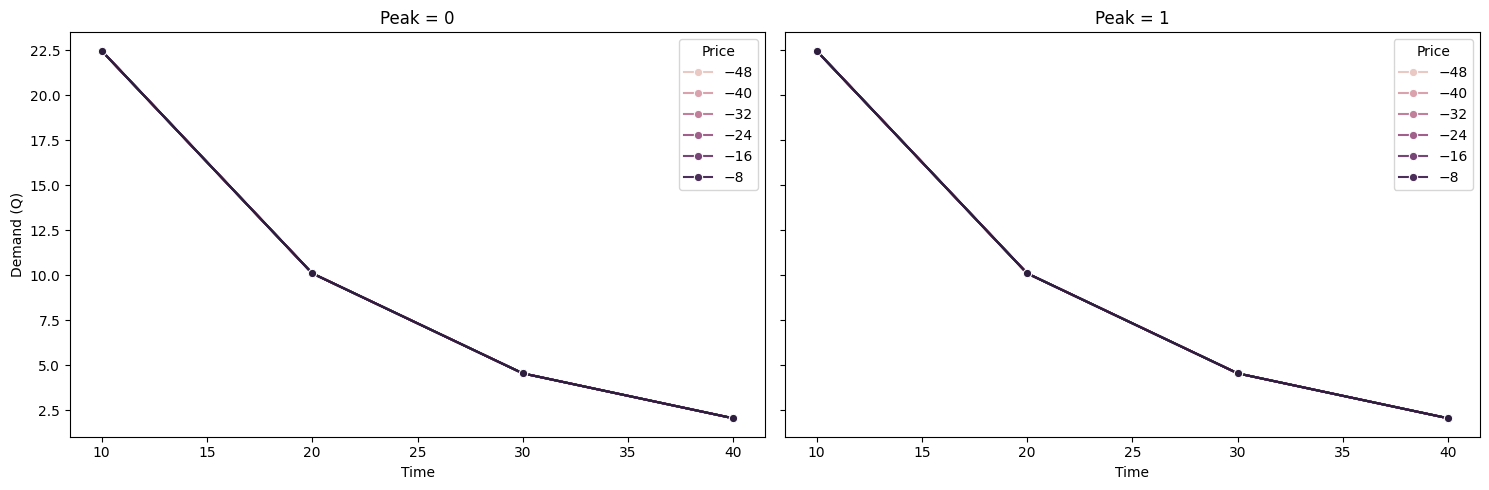

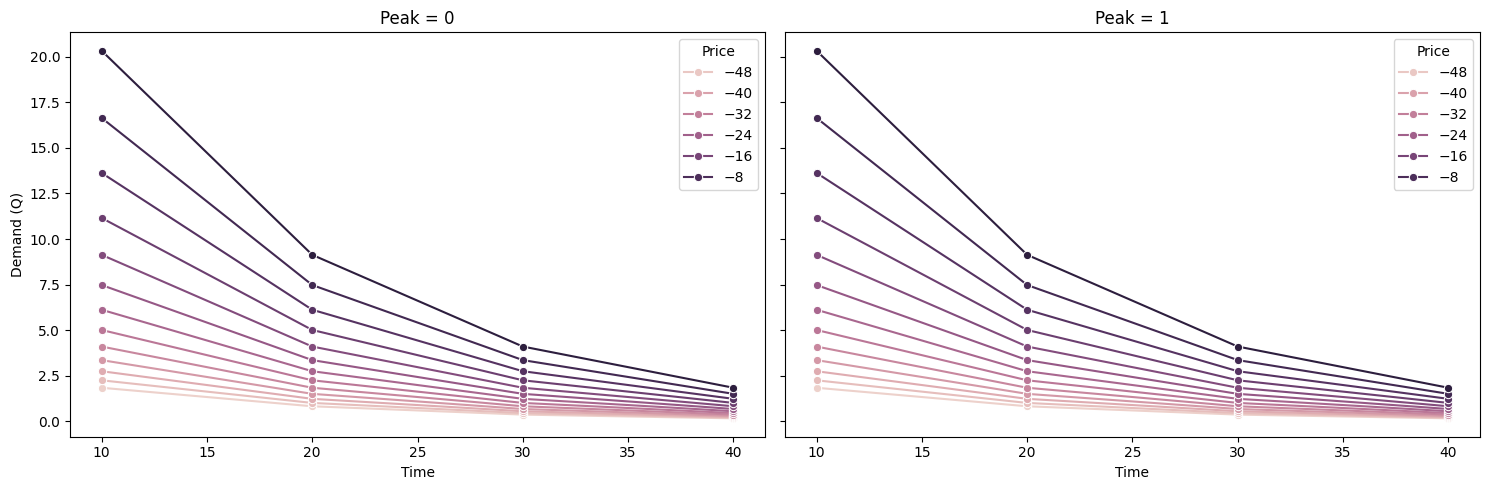

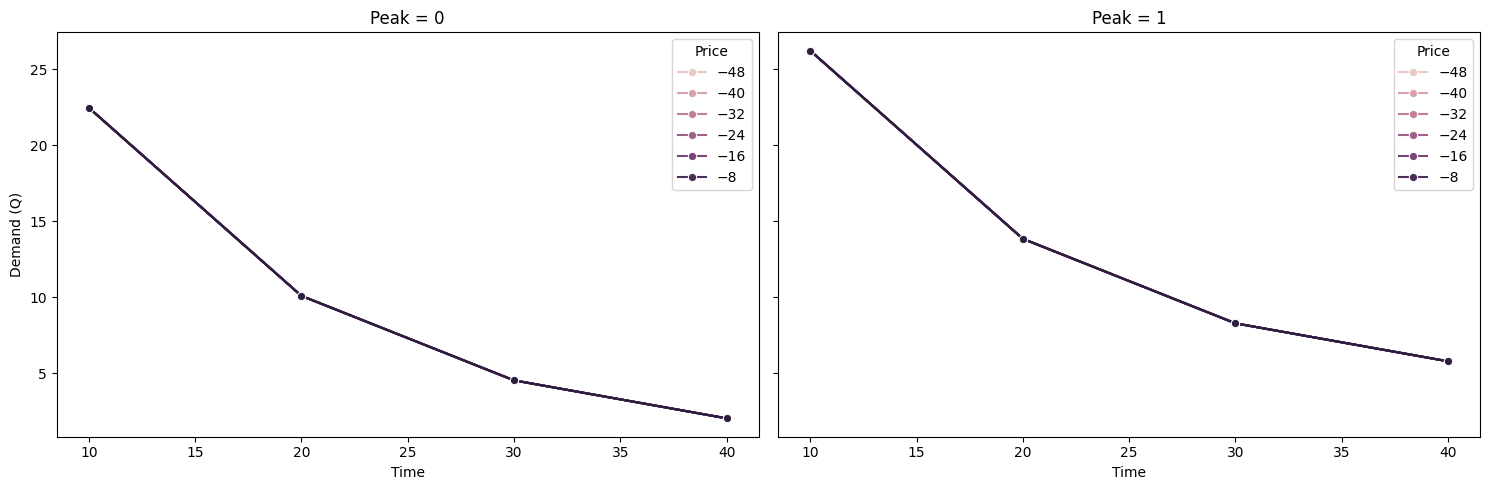

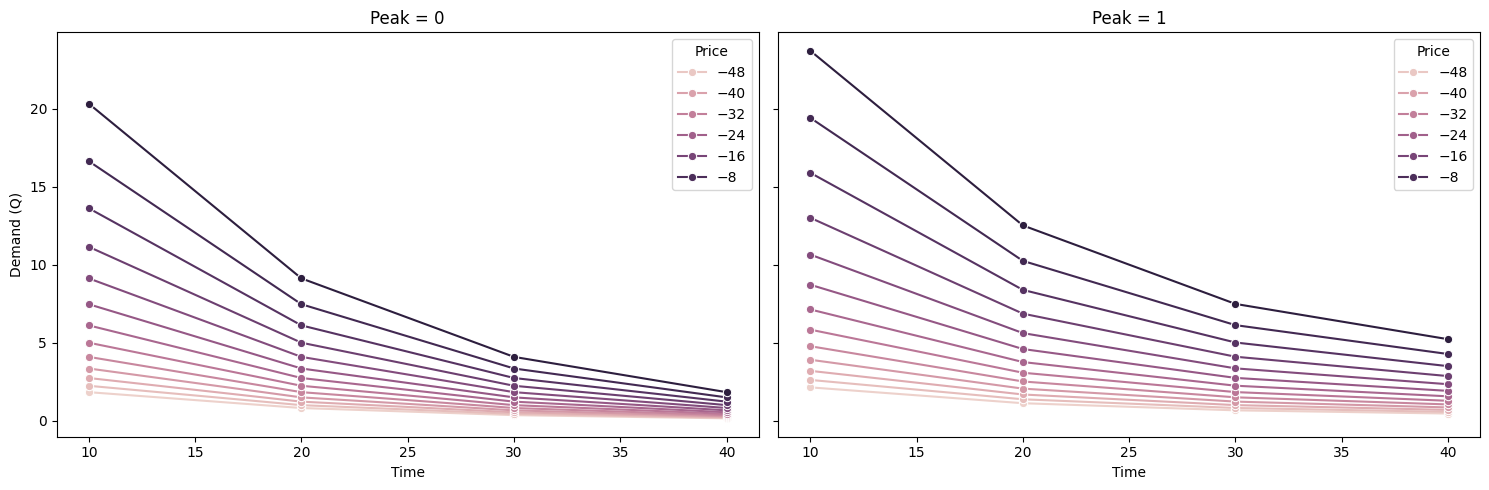

In [5]:
for key, params in BENCHMARKS.items():
    
    # Create a data frame with every combination of action, time, and peak
    peak = [0, 1]
    price = params['prices']
    time = np.arange(-params['num_periods'], 1)

    df = pd.DataFrame(
        [(p, t, pk) for p in price for t in time for pk in peak],
        columns=["price", "time", "peak"]
    )

    df['q'] = df.apply(
        lambda row: DummyData(**params).demand_curve(
            price=np.array([row['price']]),
            t=np.array([row['time']]),
            peak=np.array([row['peak']]),
        )[0],
        axis=1
    )

    # Pick a subset of times to plot for 
    times_to_plot = np.arange(-params['num_periods'], 0, 4)
    df_subset = df[df['time'].isin(times_to_plot)]
    df_subset = df_subset.sort_values(by=['time', 'peak', 'price'])

    # 2 charts: one for peak = 0 and one for peak = 1
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    for peak_value in [0, 1]:
        df_peak = df_subset[df_subset['peak'] == peak_value]
        sns.lineplot(
            data=df_peak,
            x='price',
            y='q',
            hue='time',
            ax=ax[peak_value],
            marker='o'
        )
        ax[peak_value].set_title(f"Peak = {peak_value}")
        ax[peak_value].set_xlabel("Time")
        ax[peak_value].set_ylabel("Demand (Q)")
        ax[peak_value].legend(title="Price")
    plt.tight_layout()
    plt.show()

### Solve

Solving MDP with parameters: {'num_periods': 50, 'price_effect': 0.08, 'peak_effect': 0, 'time_effect': 0.0, 
'capacity': 500, 'prices': [10, 20, 30, 40]}

INFO:markov_decision_process.time_augmented_mdp:Mode not set. Inferring mode...
INFO:markov_decision_process.time_augmented_mdp:Reward function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Transition function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Reward and transition functions are vectorized. Setting mode to "vectorized"
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...


INFO:markov_decision_process.time_augmented_mdp:MDP solved


Plotting solutions for period -50

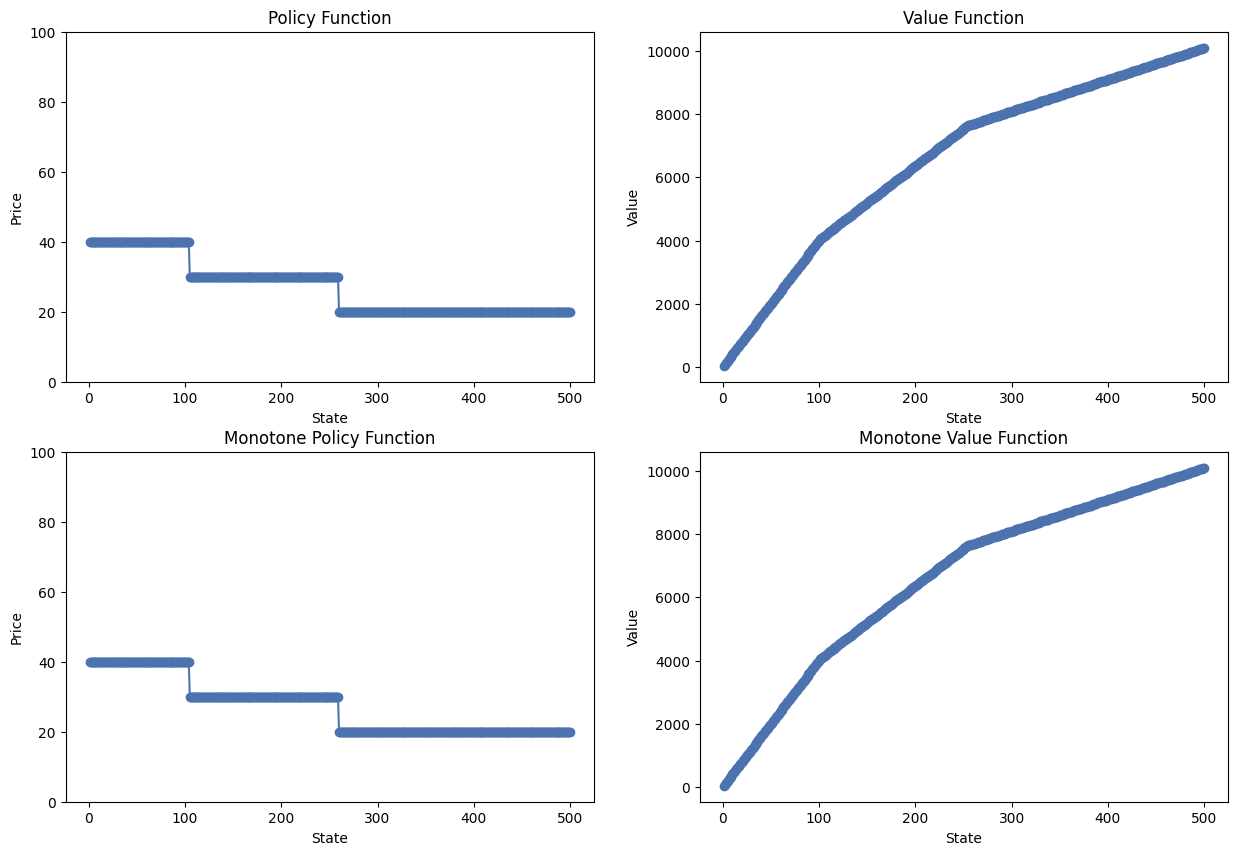

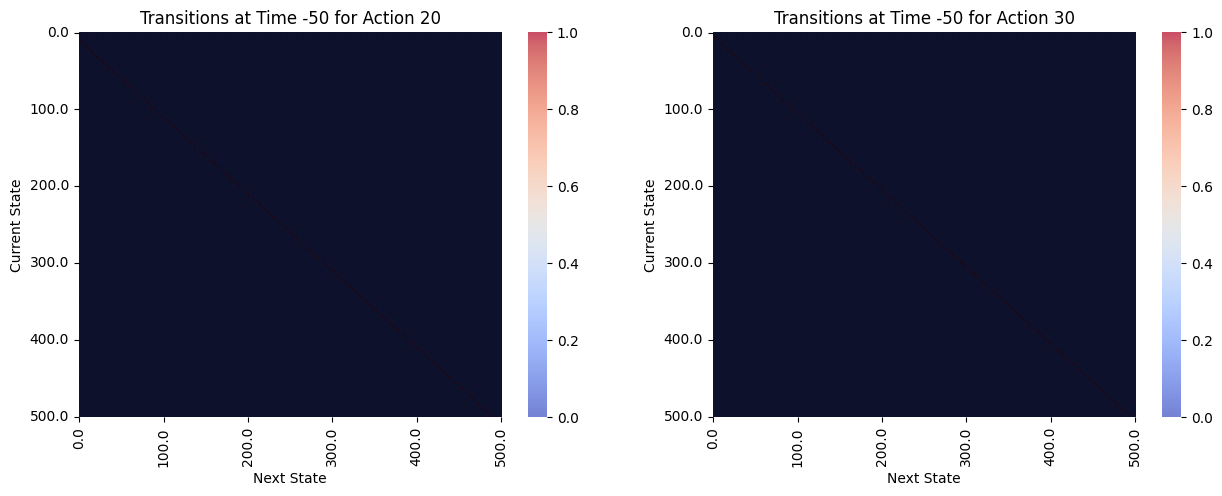

Plotting solutions for period -26

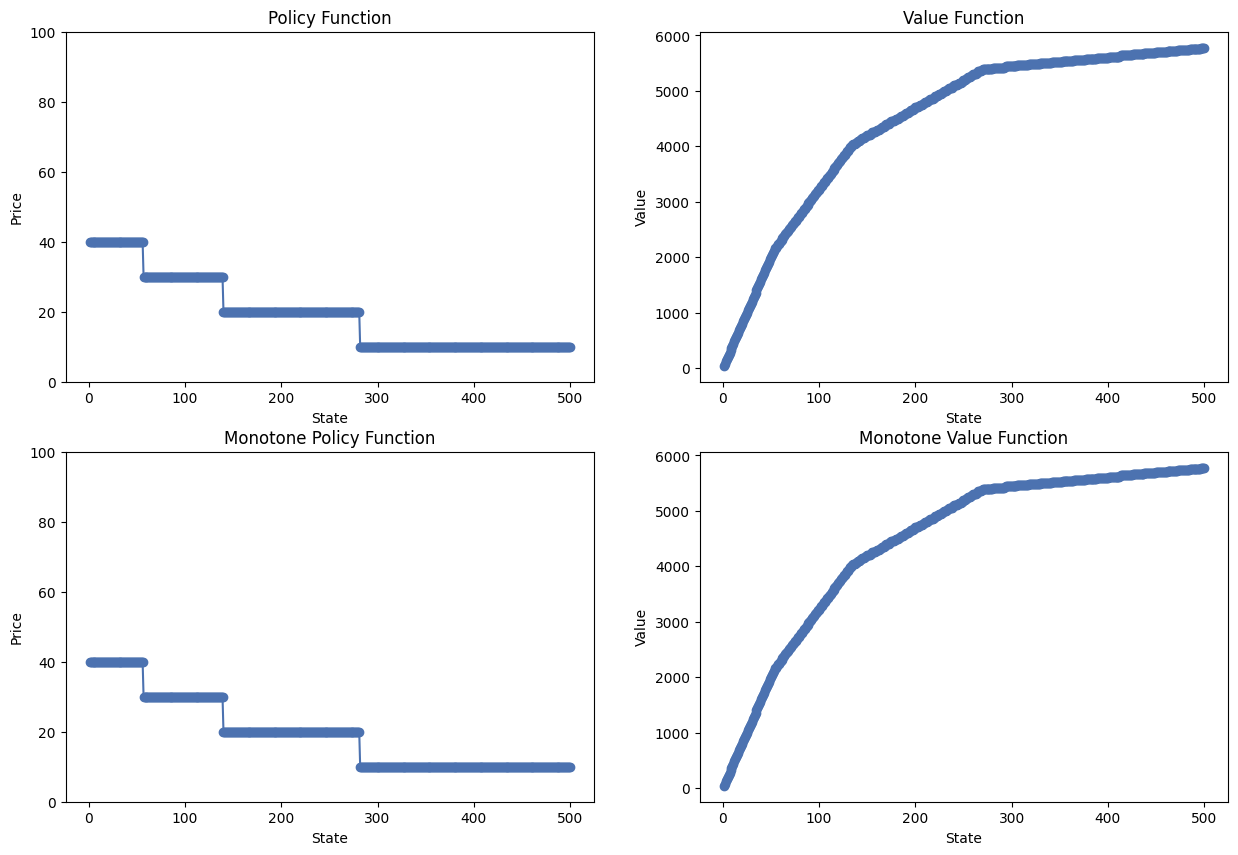

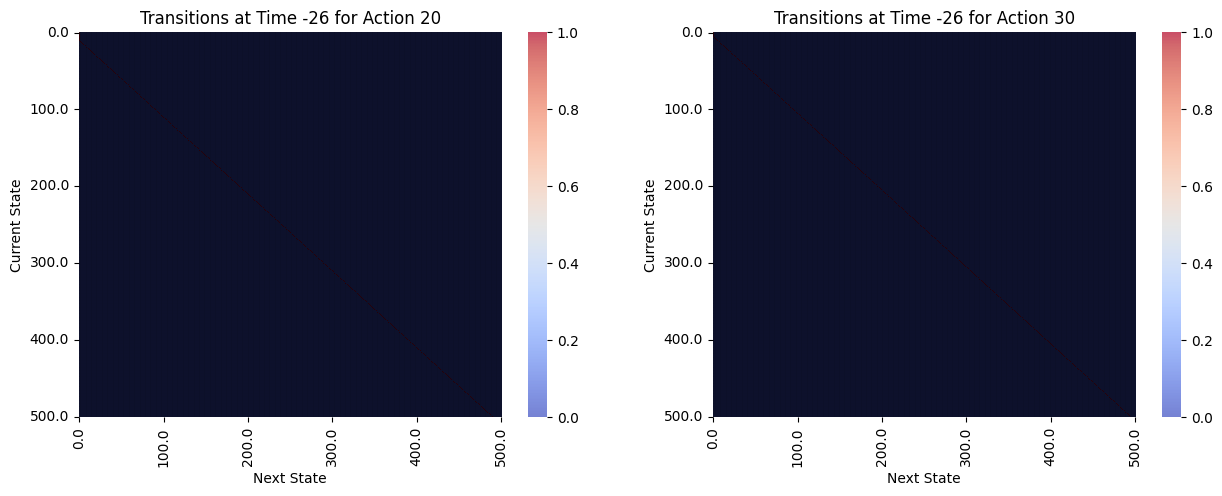

Plotting solutions for period -1

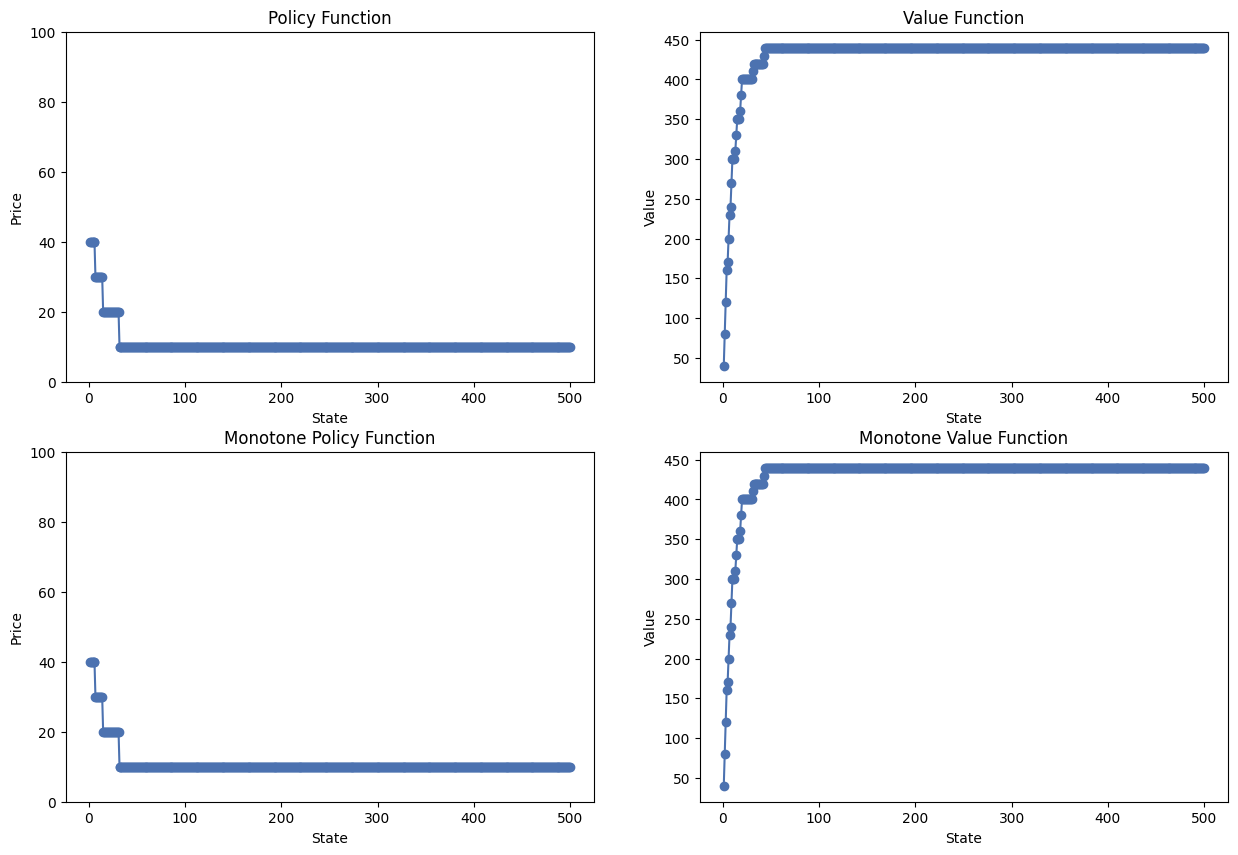

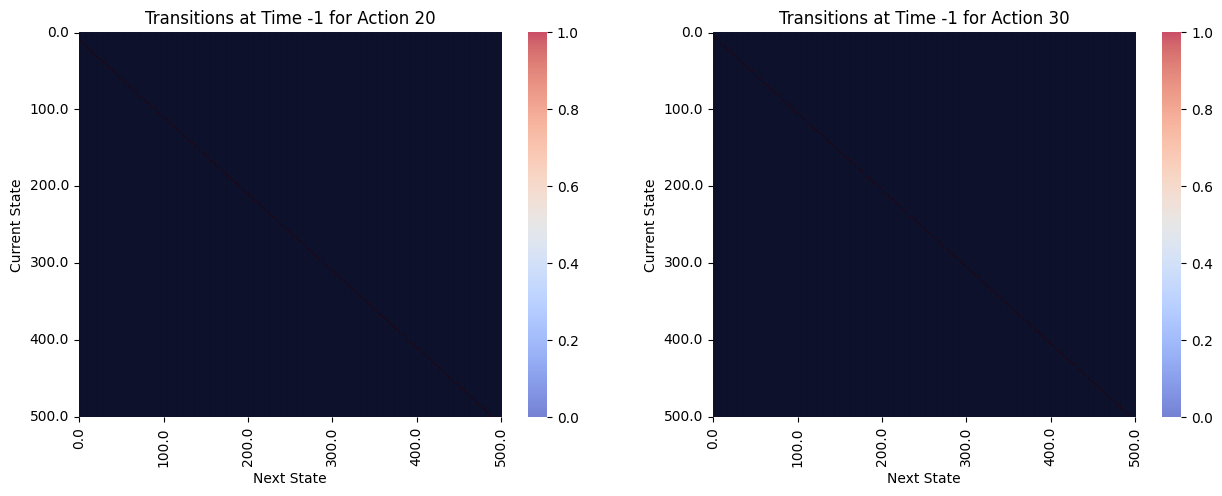

In [6]:
run_diagnostic(BENCHMARKS['static-demand'])

Solving MDP with parameters: {'num_periods': 50, 'price_effect': 0.08, 'peak_effect': 0, 'time_effect': 0.05, 
'capacity': 500, 'prices': [10, 20, 30, 40]}

INFO:markov_decision_process.time_augmented_mdp:Mode not set. Inferring mode...
INFO:markov_decision_process.time_augmented_mdp:Reward function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Transition function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Reward and transition functions are vectorized. Setting mode to "vectorized"
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...


INFO:markov_decision_process.time_augmented_mdp:MDP solved


Plotting solutions for period -50

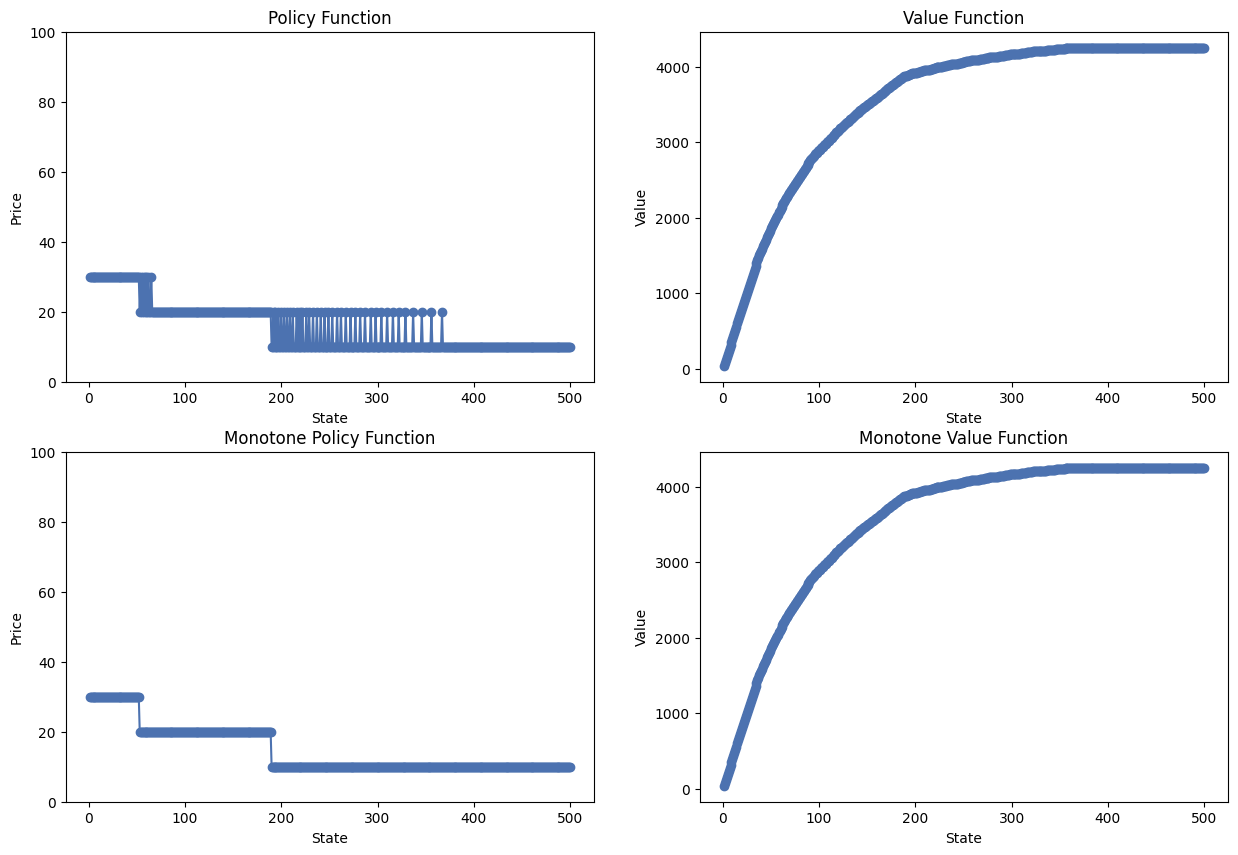

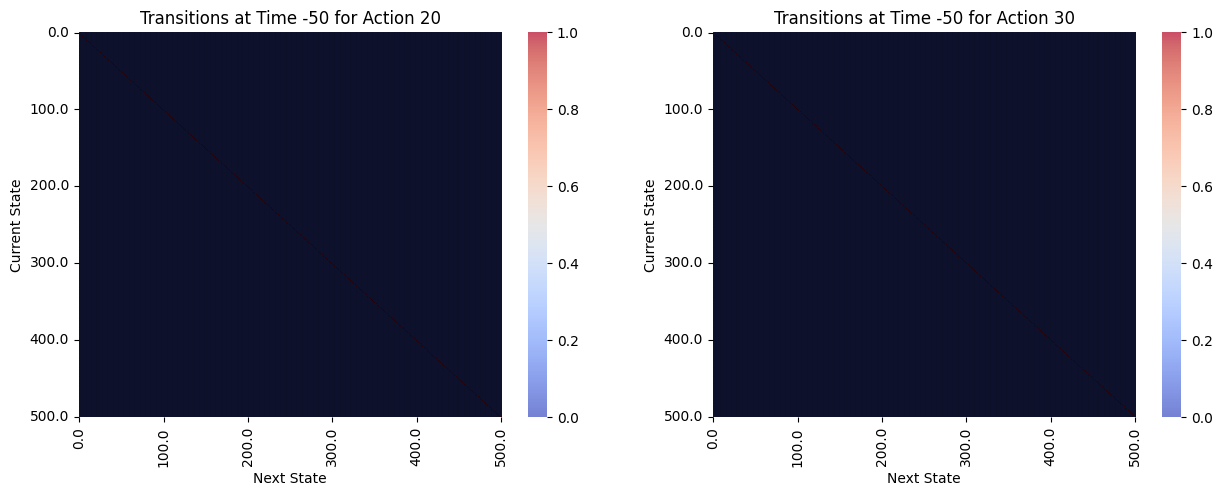

Plotting solutions for period -26

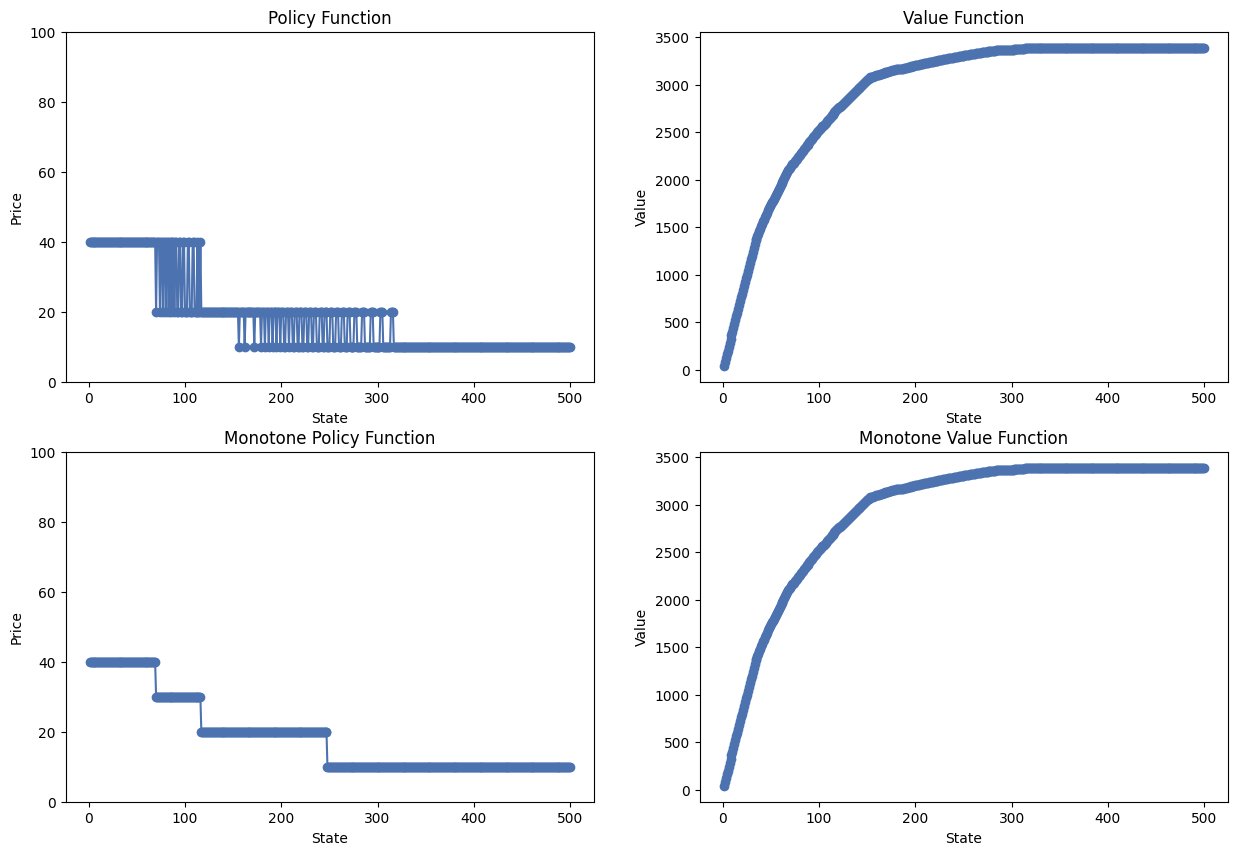

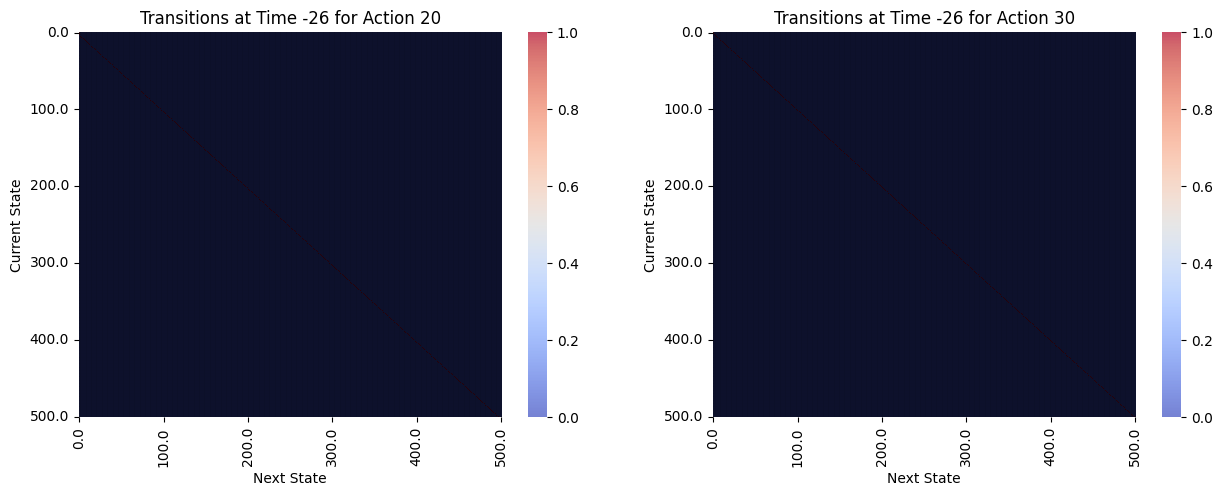

Plotting solutions for period -1

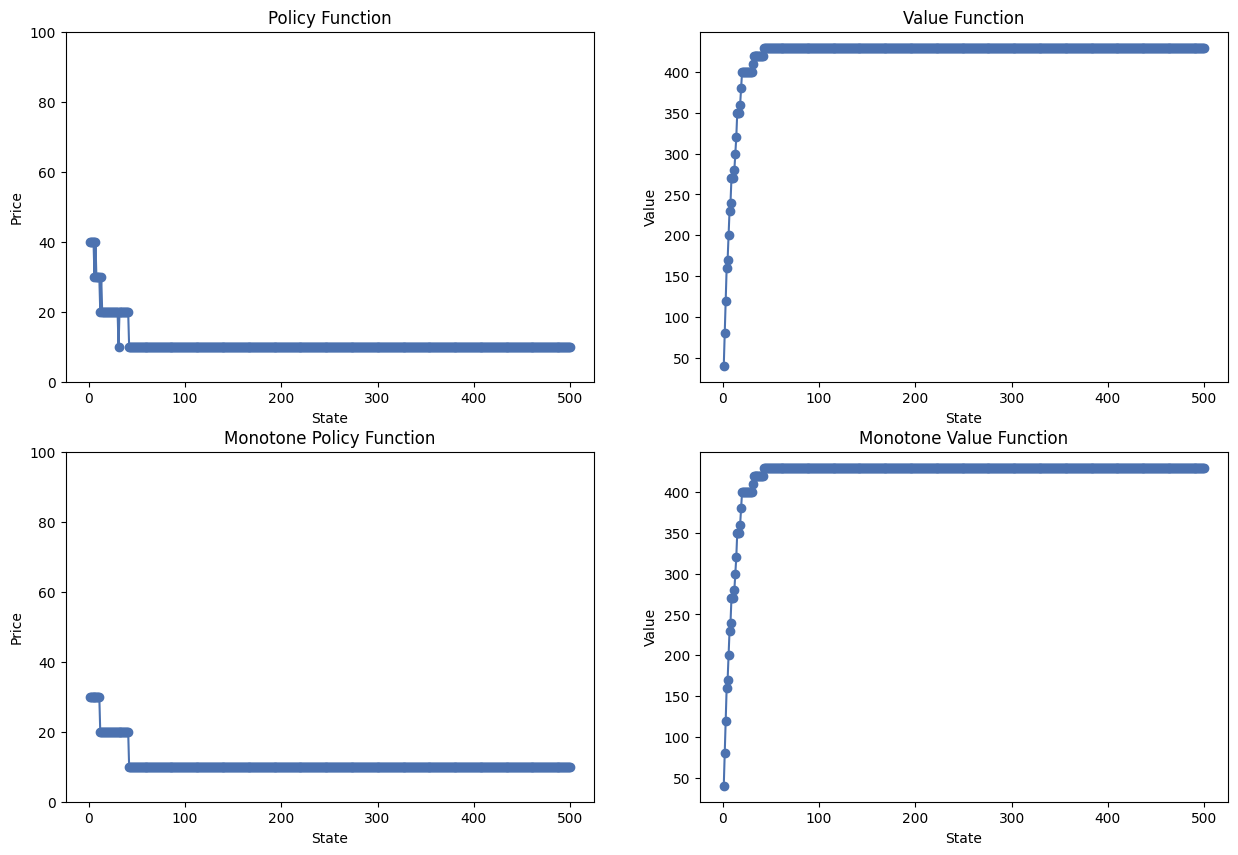

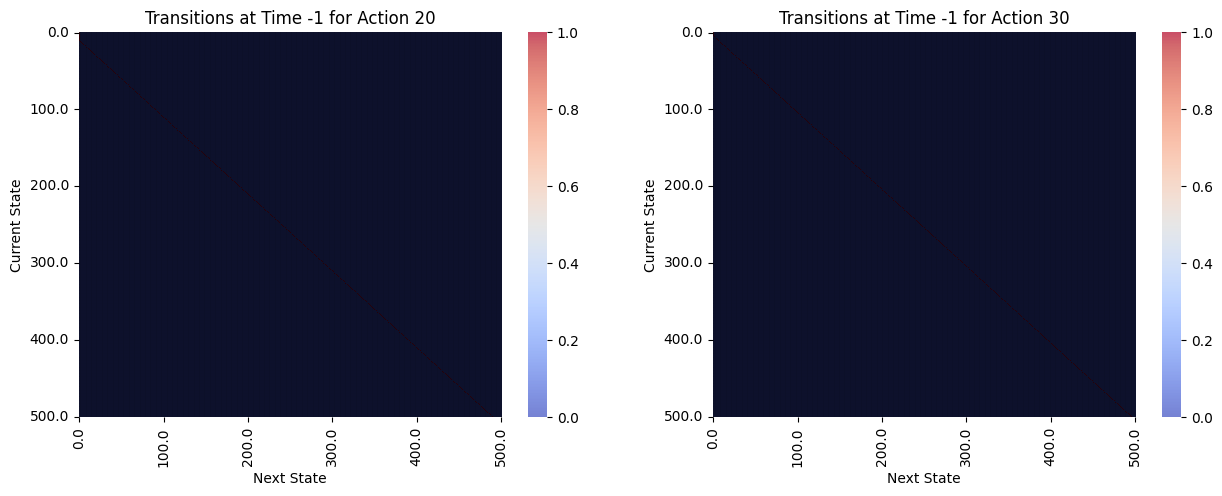

In [7]:
run_diagnostic(BENCHMARKS['time-varying-demand'])

Solving MDP with parameters: {'num_periods': 50, 'price_effect': 0.08, 'peak_effect': 0.075, 'time_effect': 0.0, 
'capacity': 500, 'prices': [10, 20, 30, 40]}

INFO:markov_decision_process.time_augmented_mdp:Mode not set. Inferring mode...
INFO:markov_decision_process.time_augmented_mdp:Reward function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Transition function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Reward and transition functions are vectorized. Setting mode to "vectorized"
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...


INFO:markov_decision_process.time_augmented_mdp:MDP solved


Plotting solutions for period -50

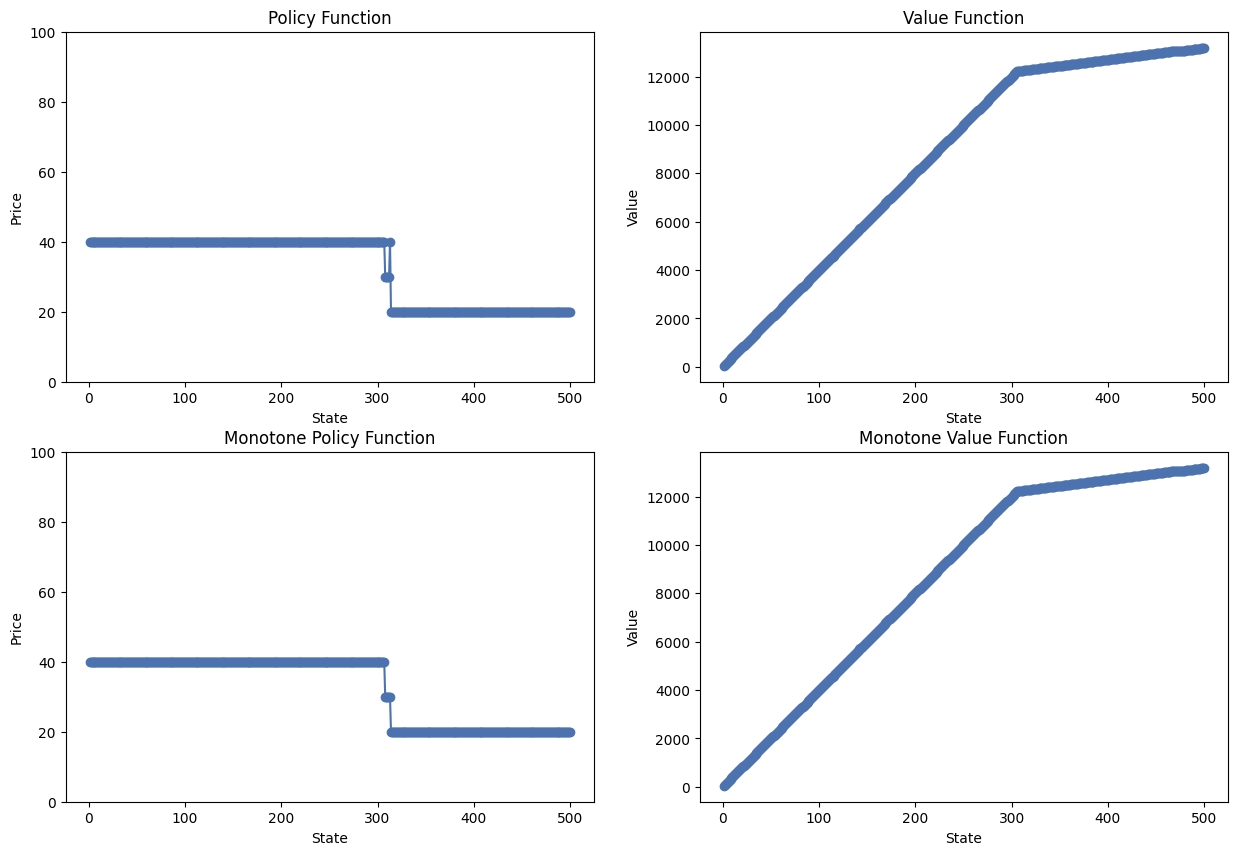

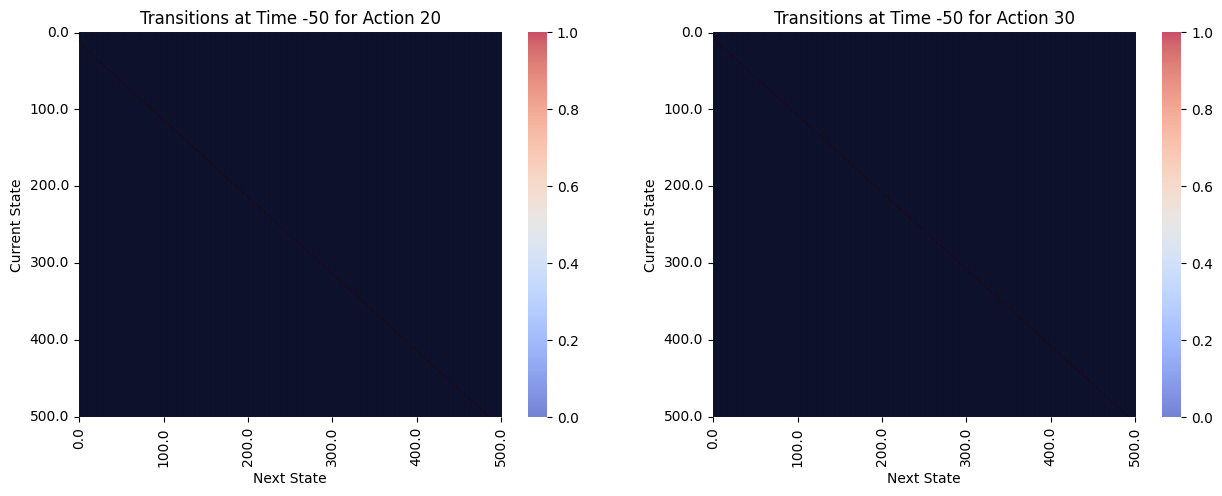

Plotting solutions for period -26

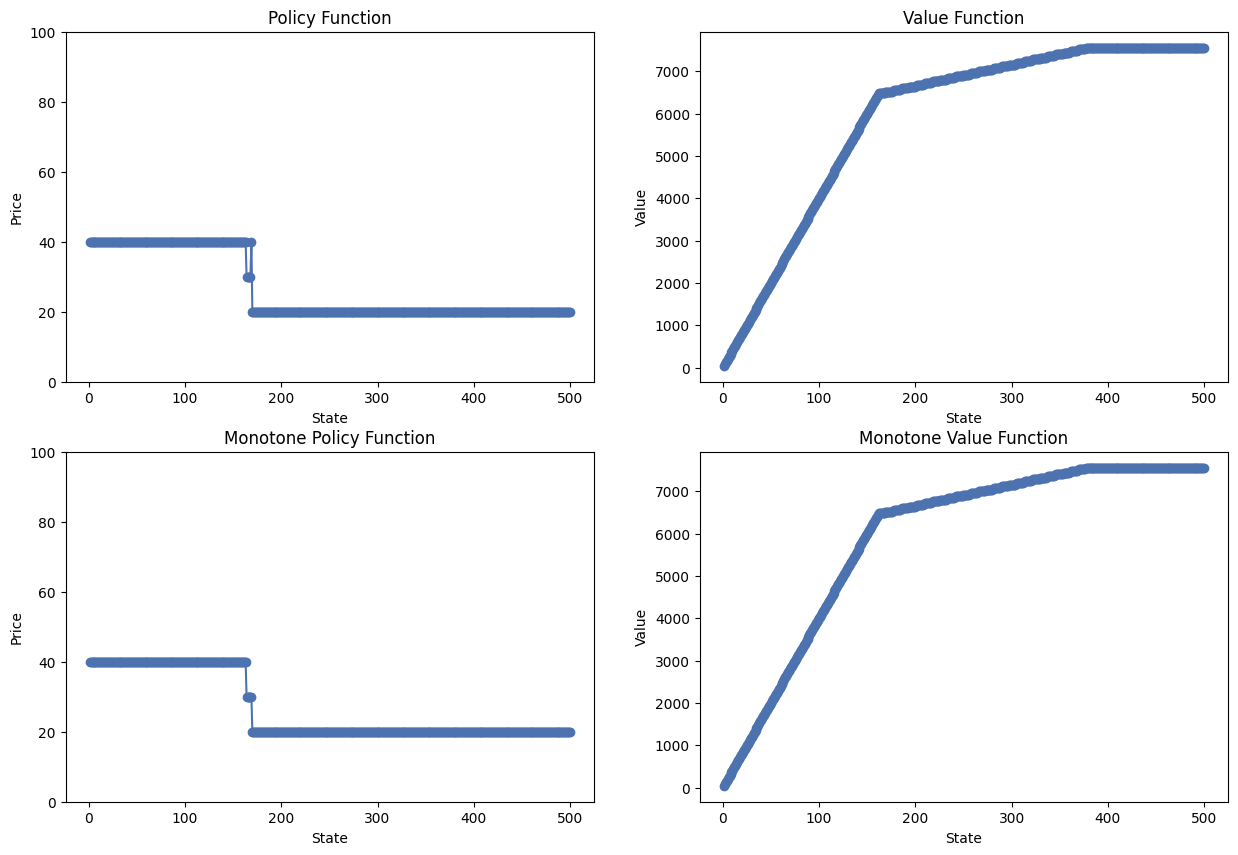

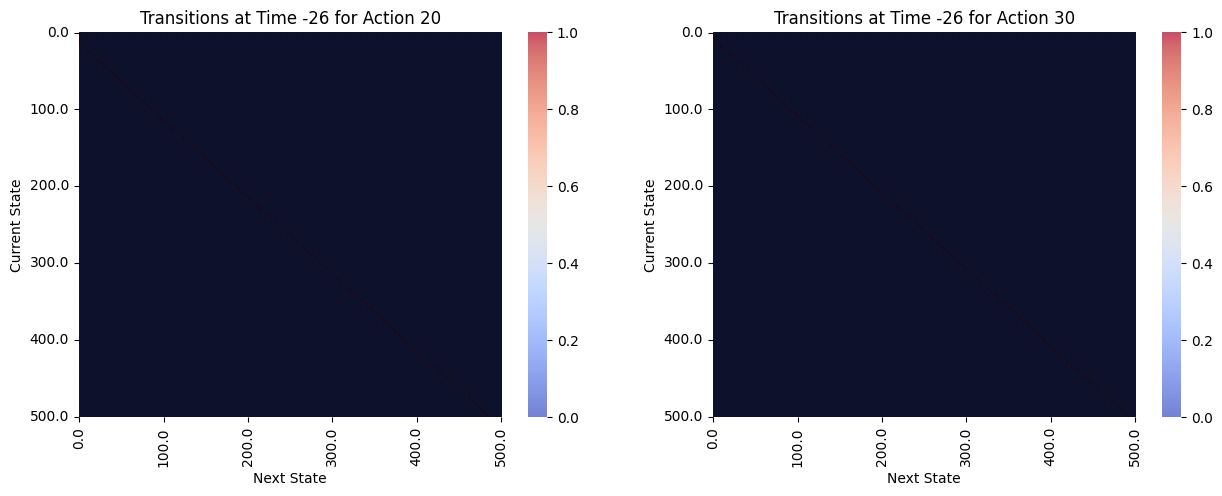

Plotting solutions for period -1

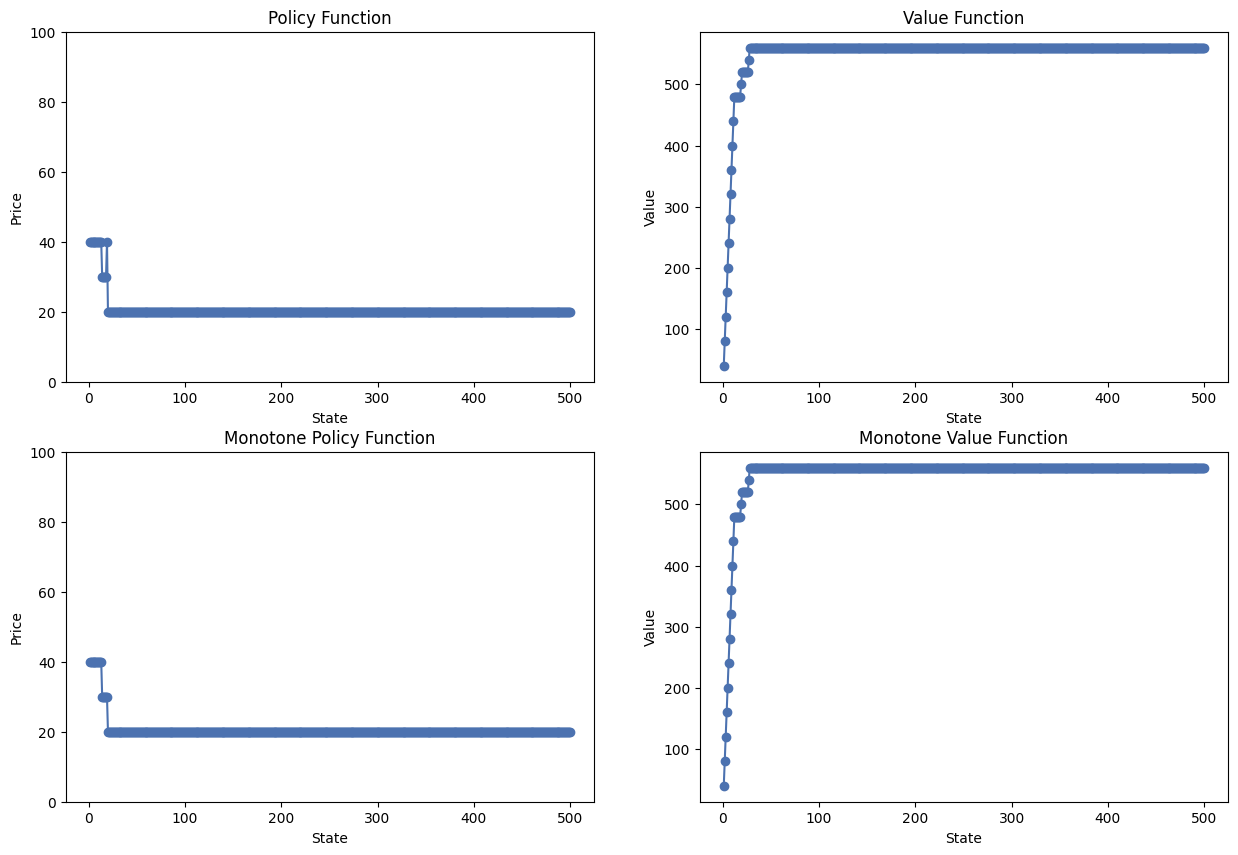

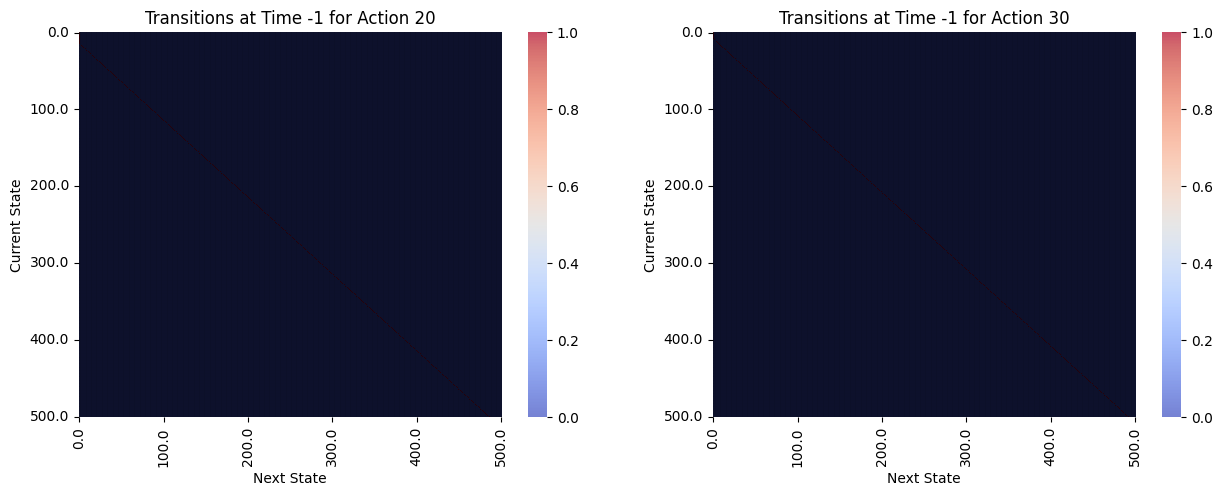

In [8]:
run_diagnostic(BENCHMARKS['peak-varying-demand'])

Solving MDP with parameters: {'num_periods': 50, 'price_effect': 0.08, 'peak_effect': 0.075, 'time_effect': 0.05, 
'capacity': 500, 'prices': [10, 20, 30, 40]}

INFO:markov_decision_process.time_augmented_mdp:Mode not set. Inferring mode...
INFO:markov_decision_process.time_augmented_mdp:Reward function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Transition function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Reward and transition functions are vectorized. Setting mode to "vectorized"
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...


INFO:markov_decision_process.time_augmented_mdp:MDP solved


Plotting solutions for period -50

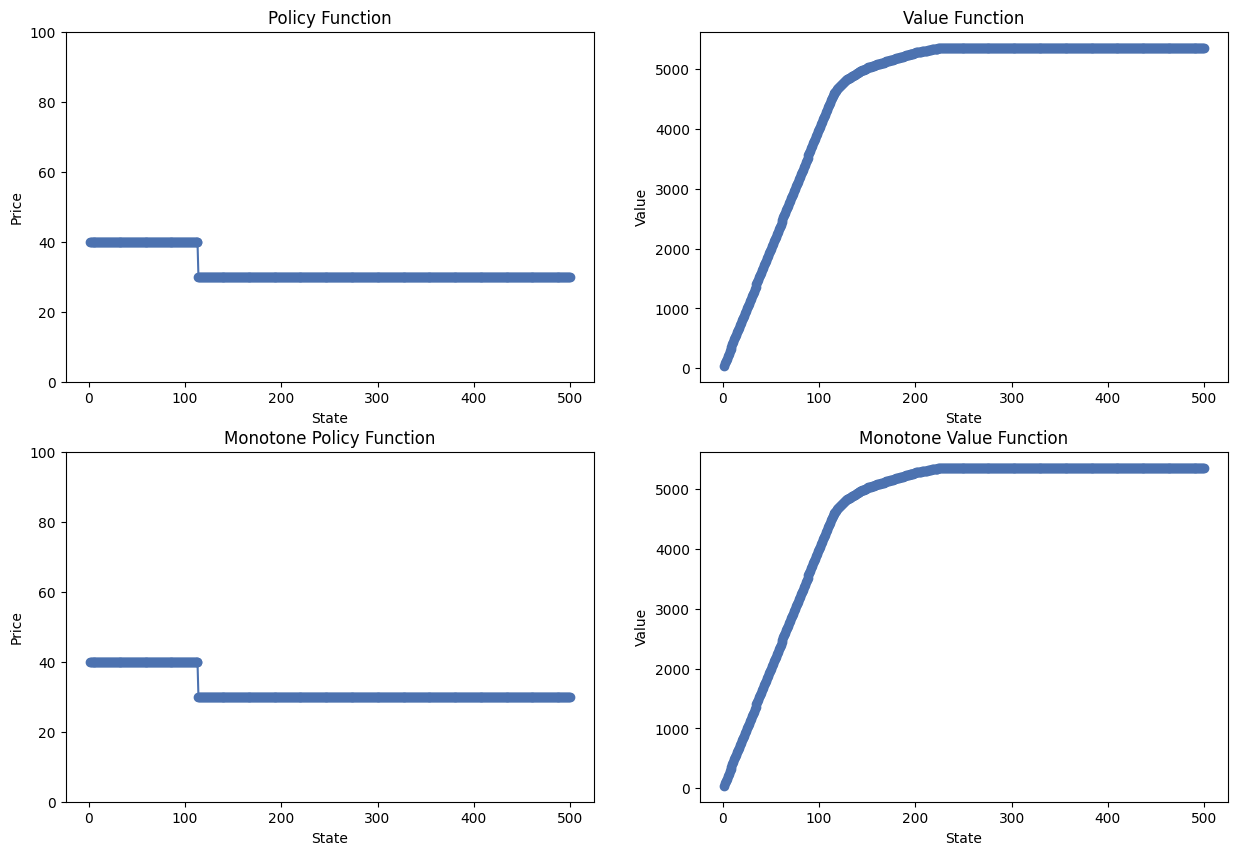

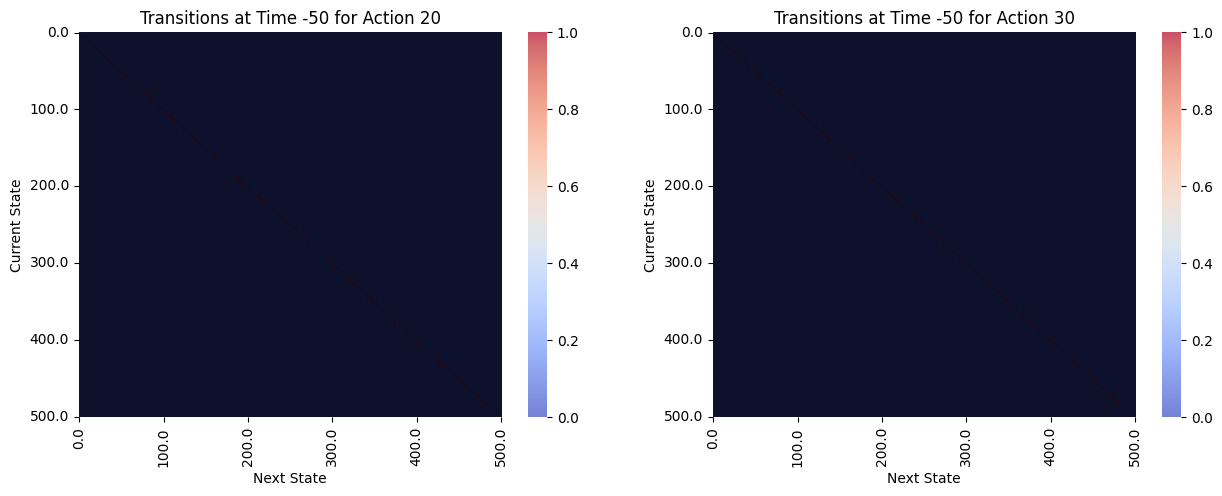

Plotting solutions for period -26

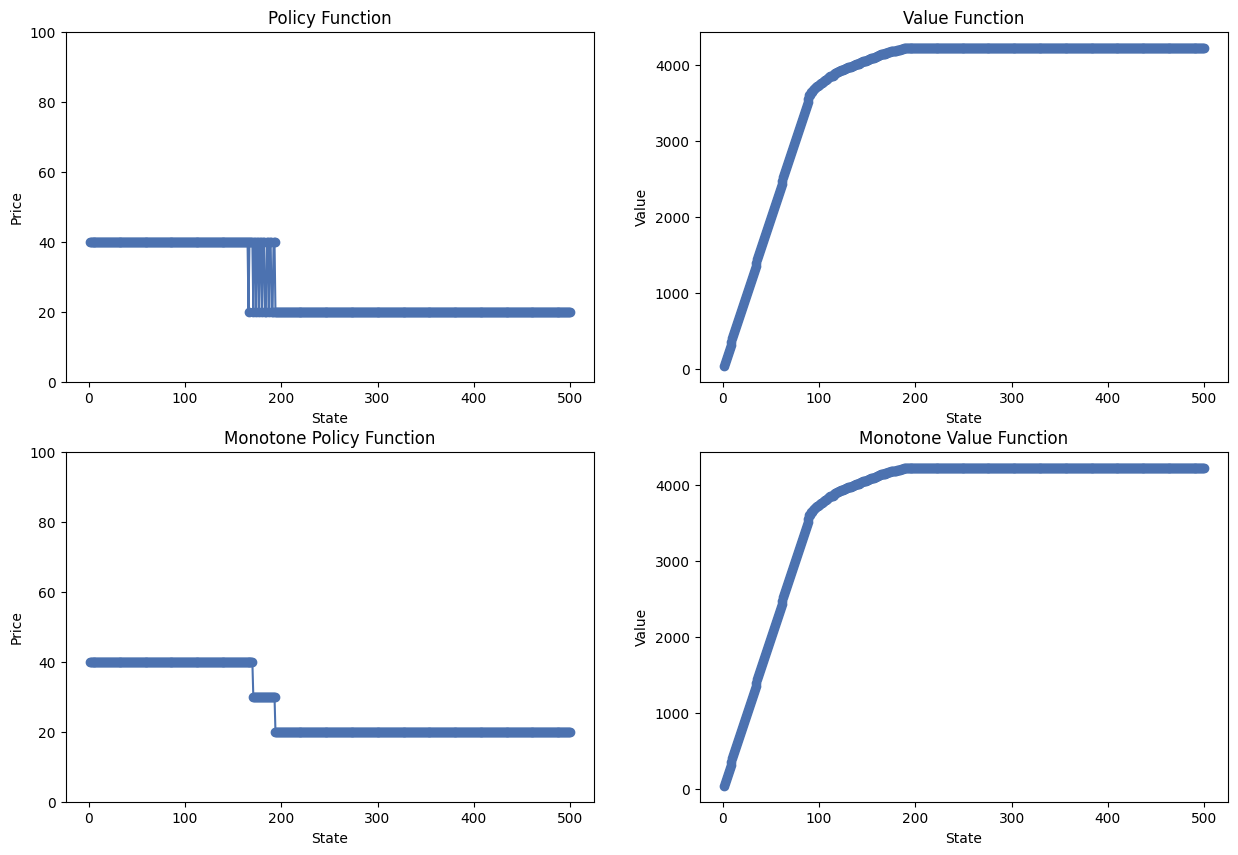

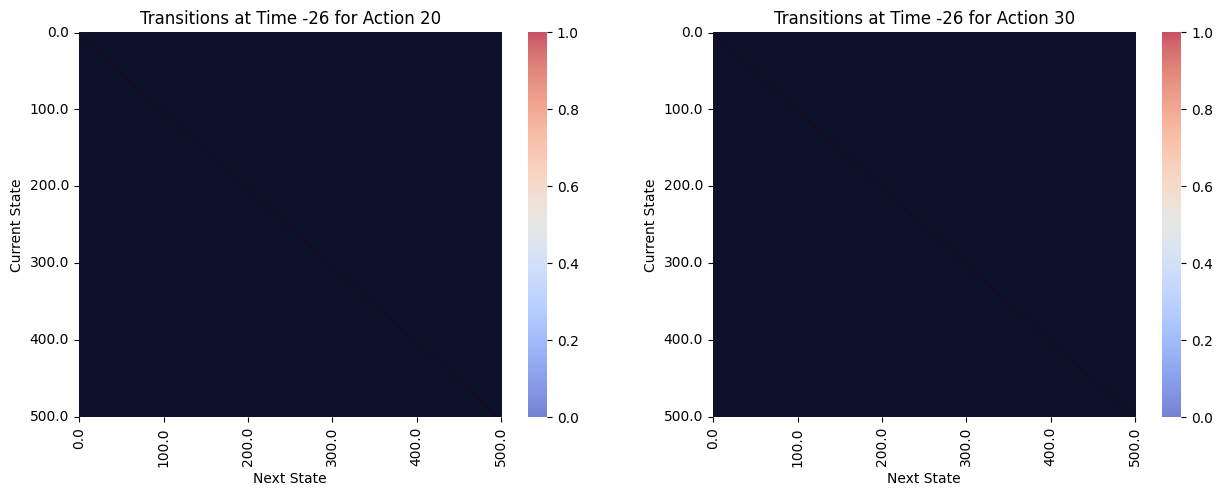

Plotting solutions for period -1

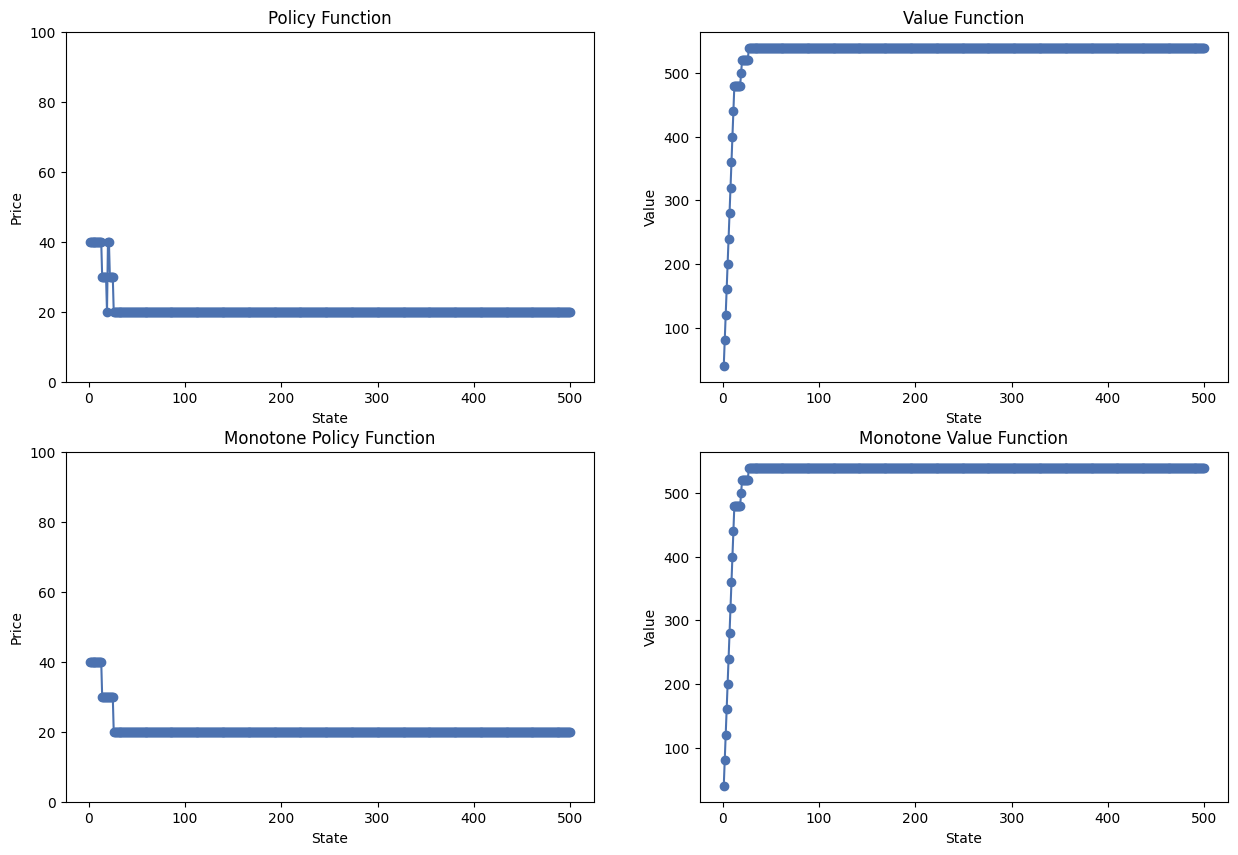

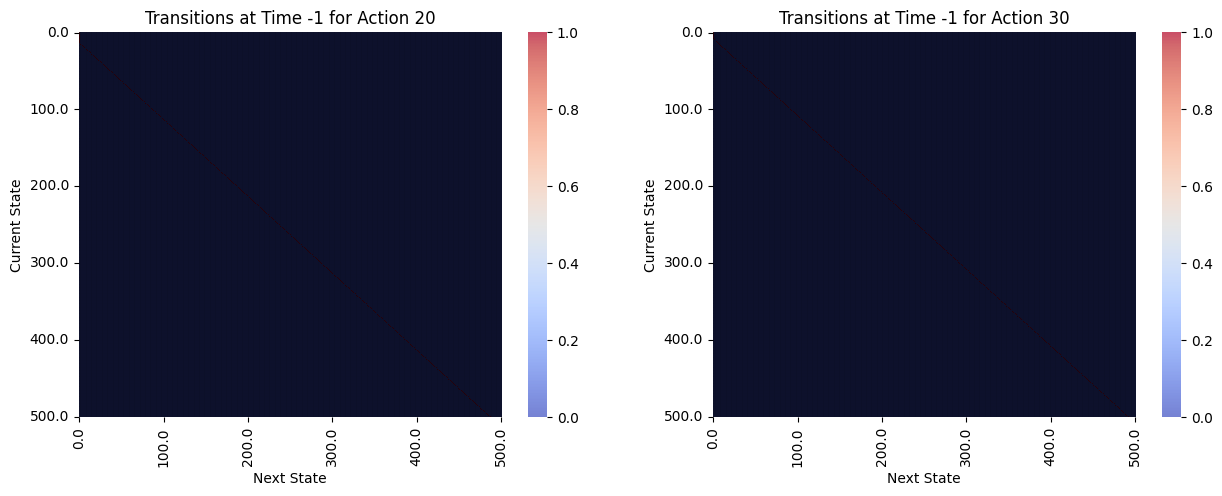

In [9]:
run_diagnostic(BENCHMARKS['all-effects'])